In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import rho_plus as rp

theme, cs = rp.mpl_setup(False)

In [2]:
def plot_logs(name):
    fig, ax = plt.subplots(figsize=(15, 10))
    df = pd.read_feather(f'exps/{name}/SAL-training_loss.feather')
    df.set_index('epoch').plot(ax=ax, lw=1)
    ax.set_ylim(0, 0.5)
    # rp.smooth_noisy_lines(keep_old_line=False)
    # rp.smooth_straight_lines
    for i in range(2, max(df.index), 3):
        ax.axvline(i, lw=0.5, alpha=0.5, color='grey')
    rp.line_labels()
    return df
# df.set_index('epoch').map(lambda x: np.log10(x + 1)).plot(ax=ax, alpha=0.05, lw=0.2, legend=None)

# df1 = plot_logs('delta_e_02-19-13-48')

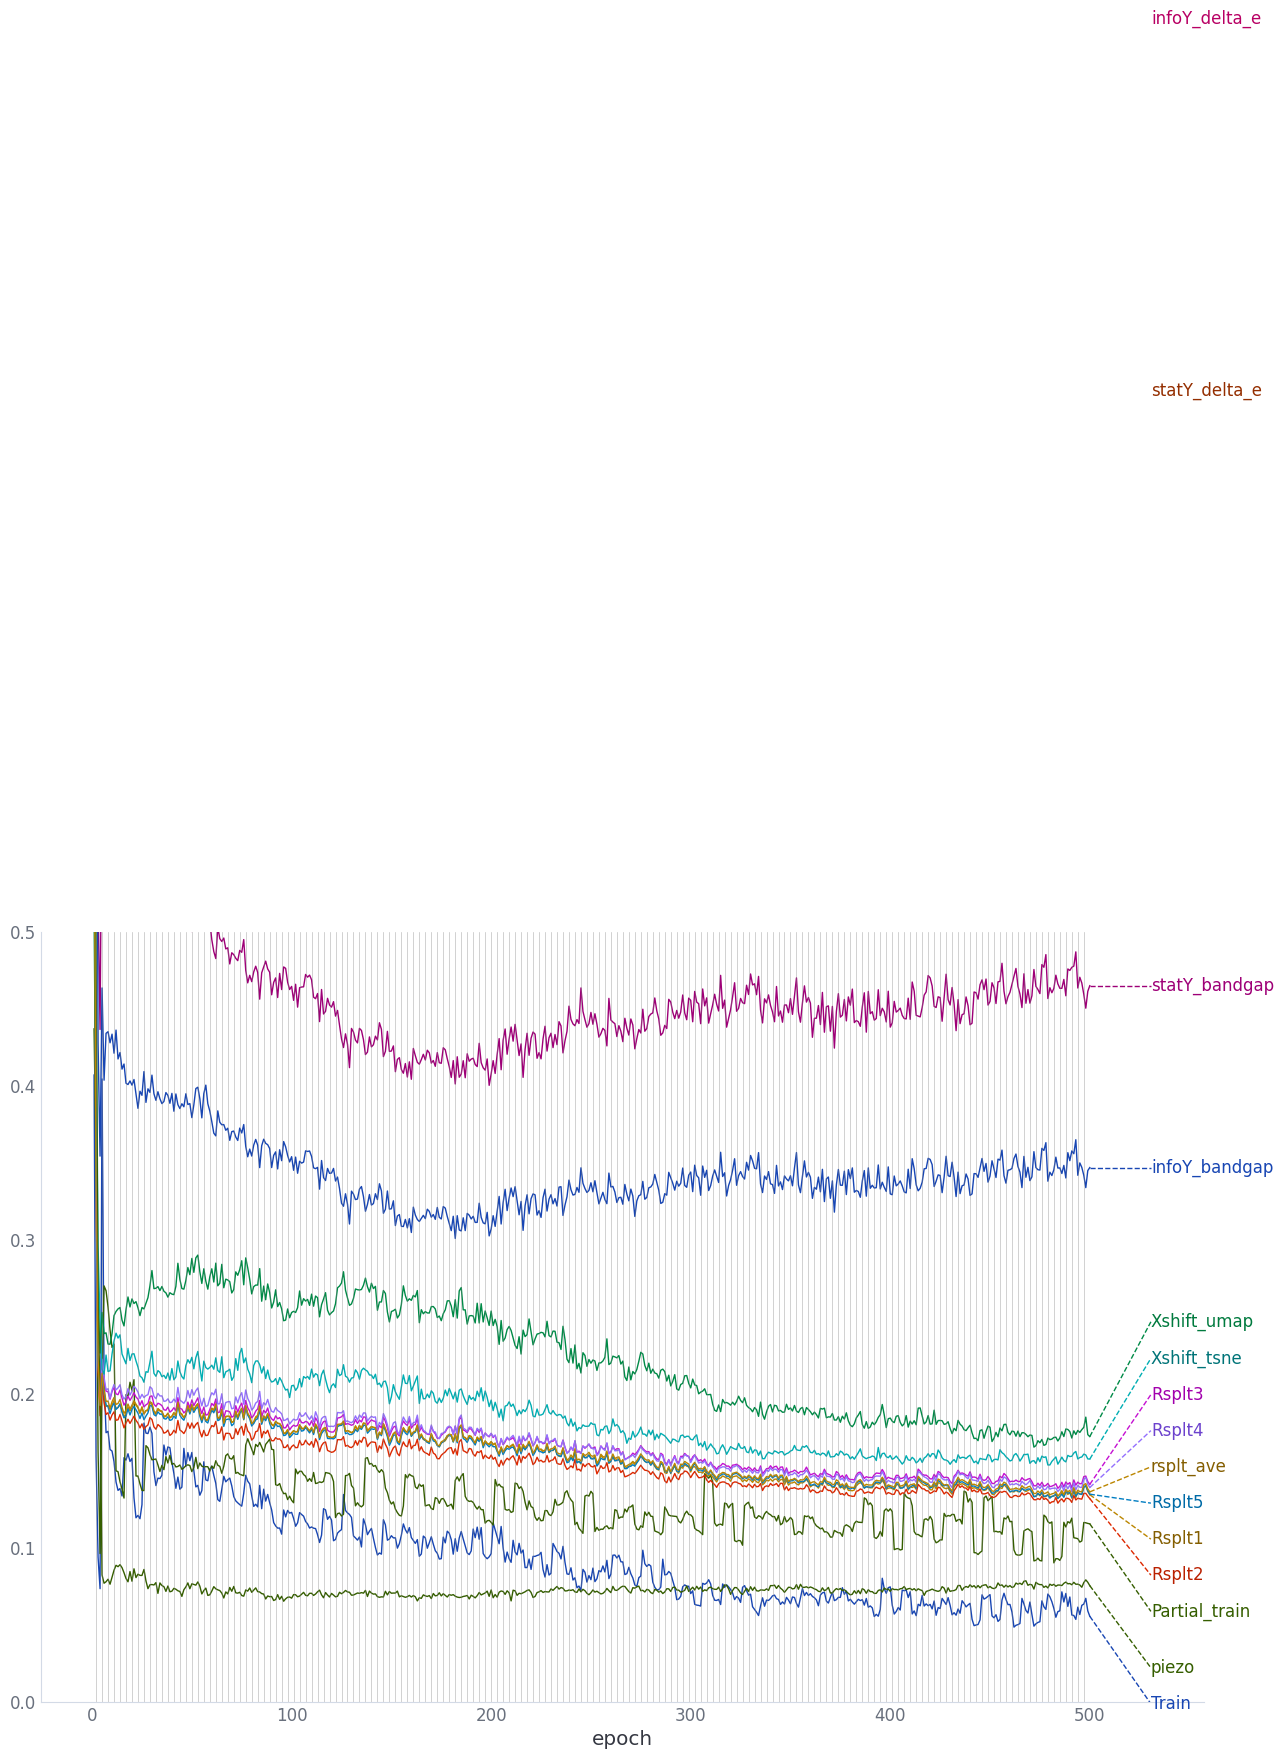

In [3]:
df2 = plot_logs('delta_e_02-23-14-26')

In [ ]:
dfp = plot_logs('delta_e_piezo')

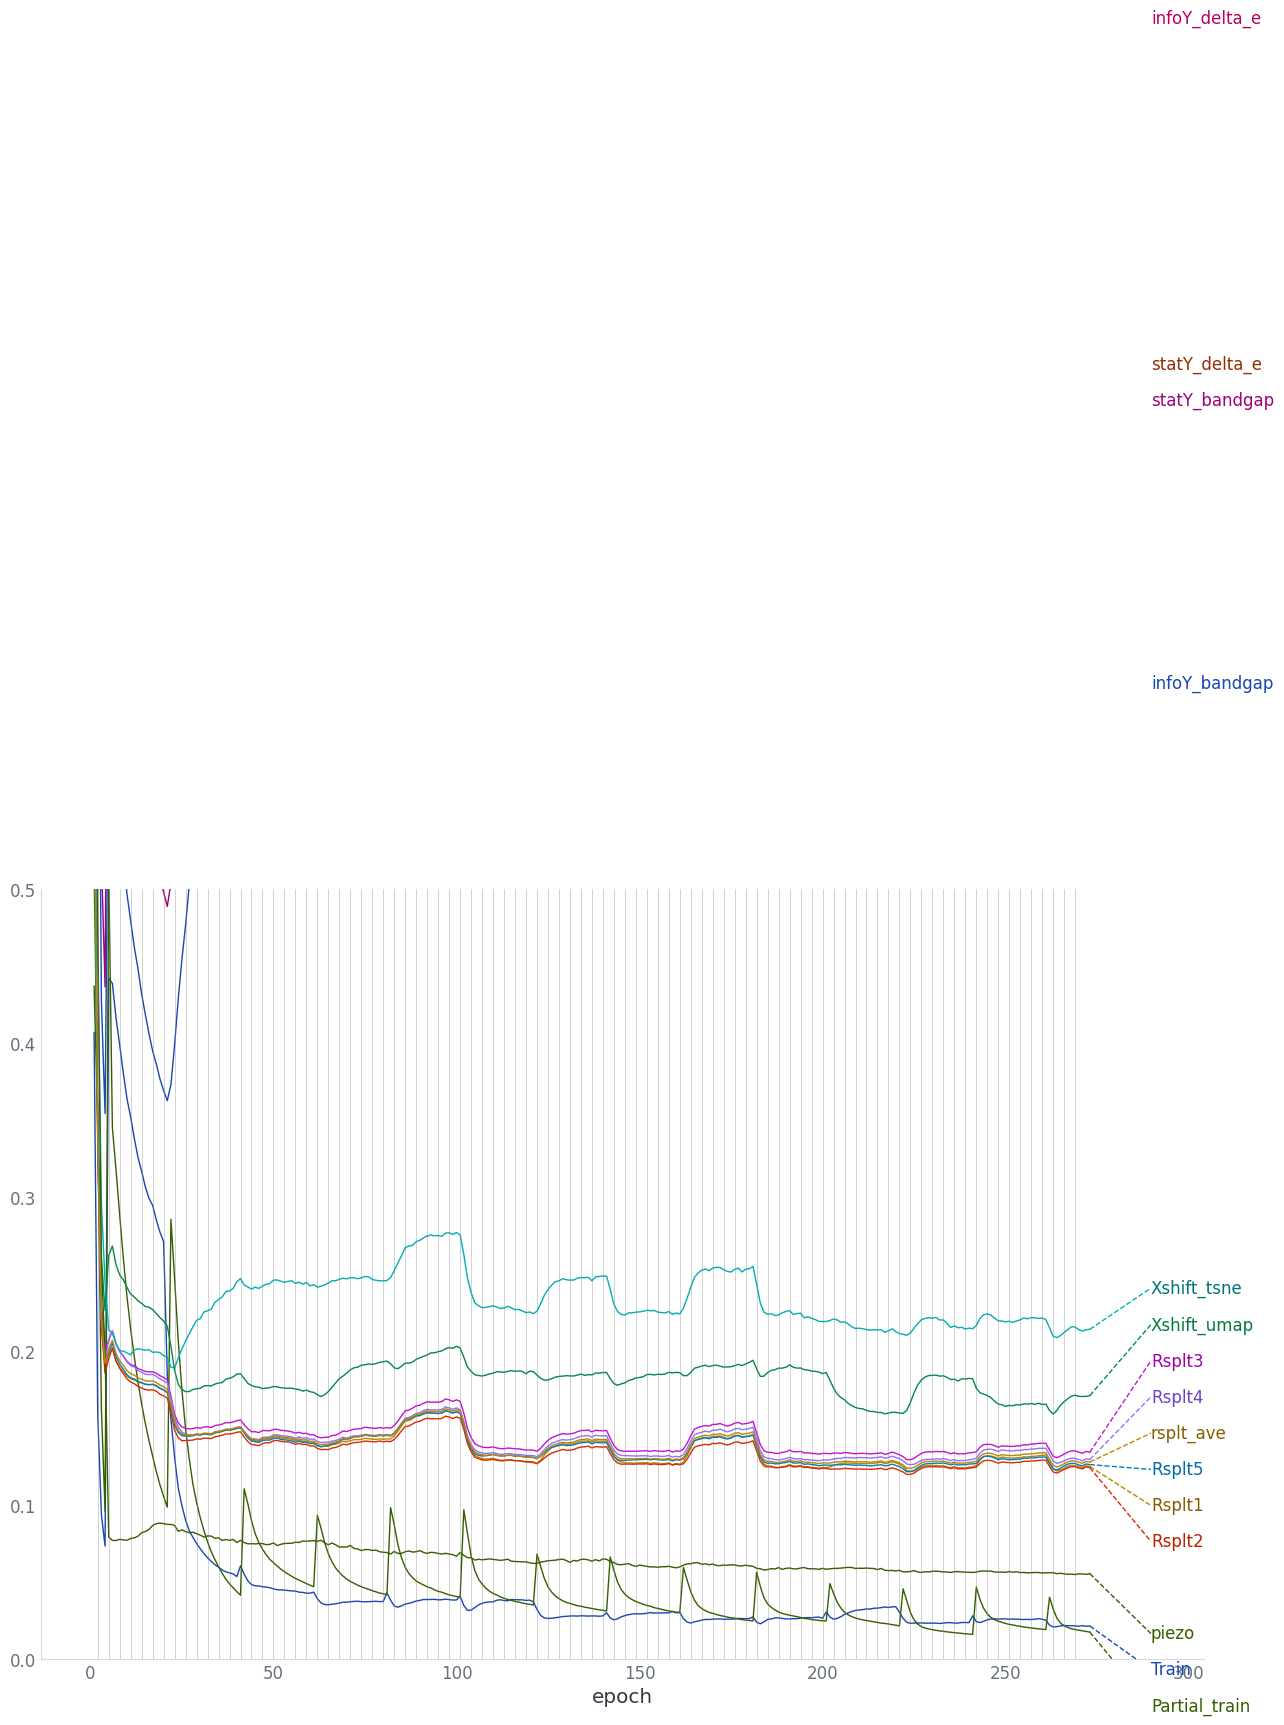

In [6]:
df2 = plot_logs('delta_e_02-23-15-45')

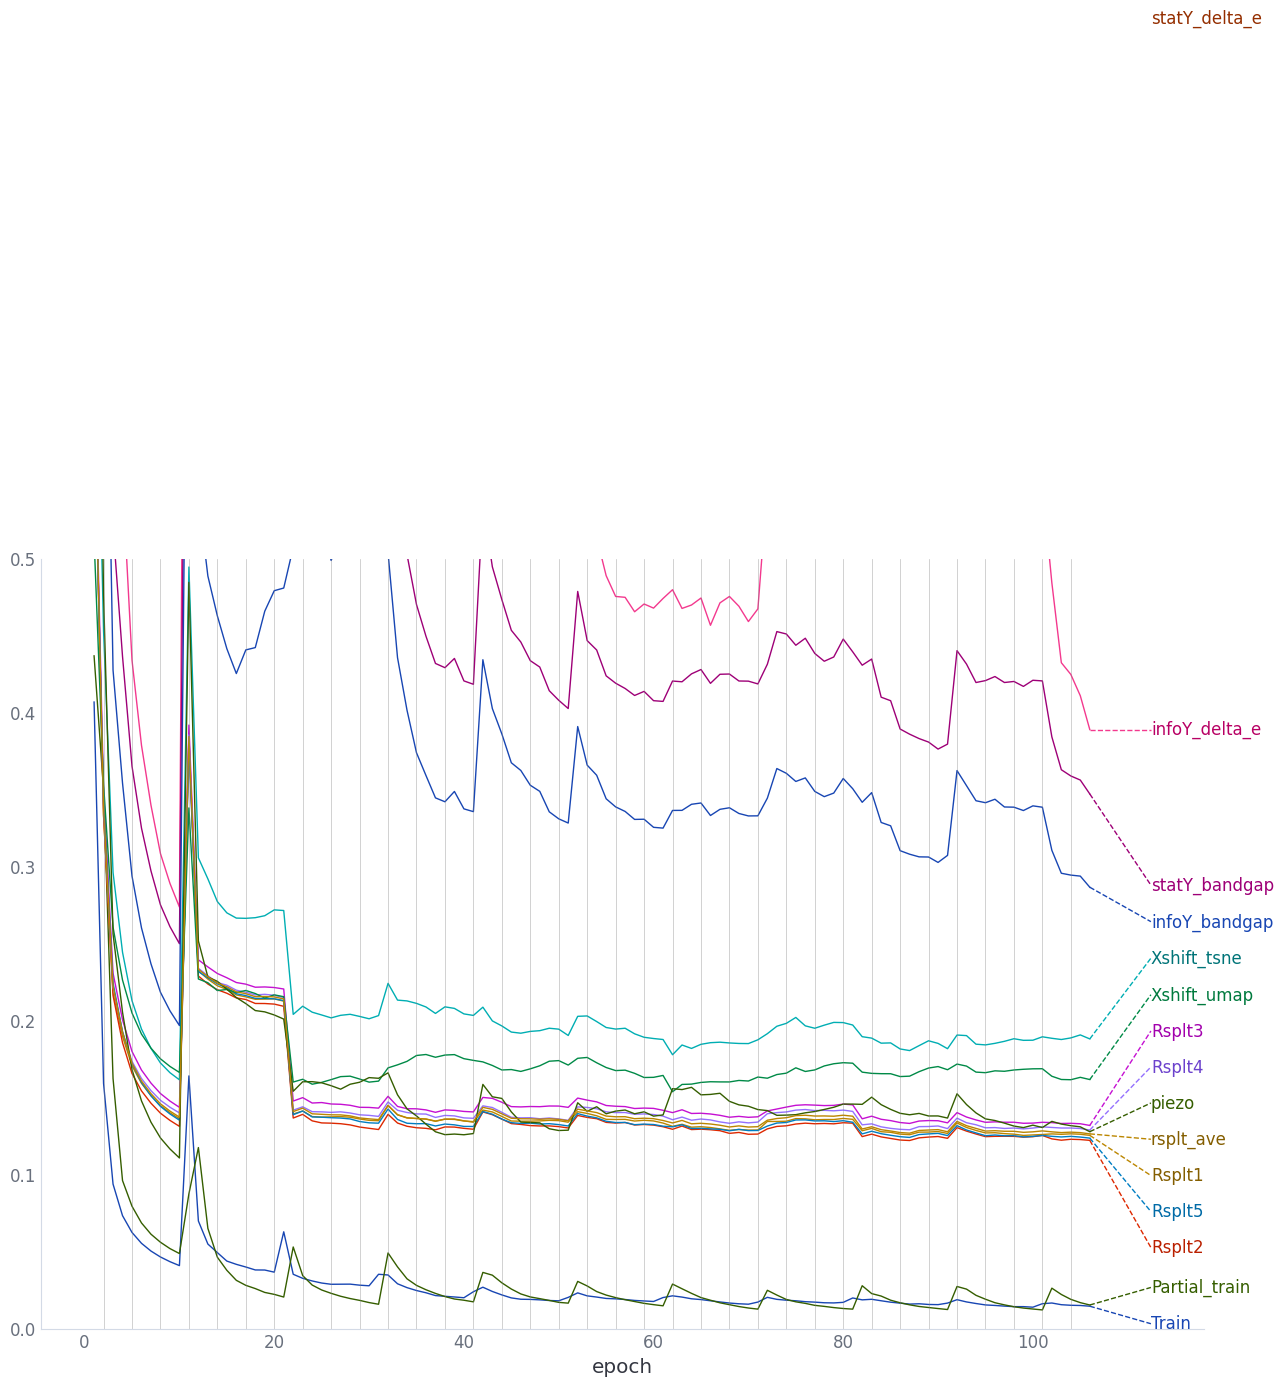

In [8]:
df2 = plot_logs('delta_e_02-23-16-34')

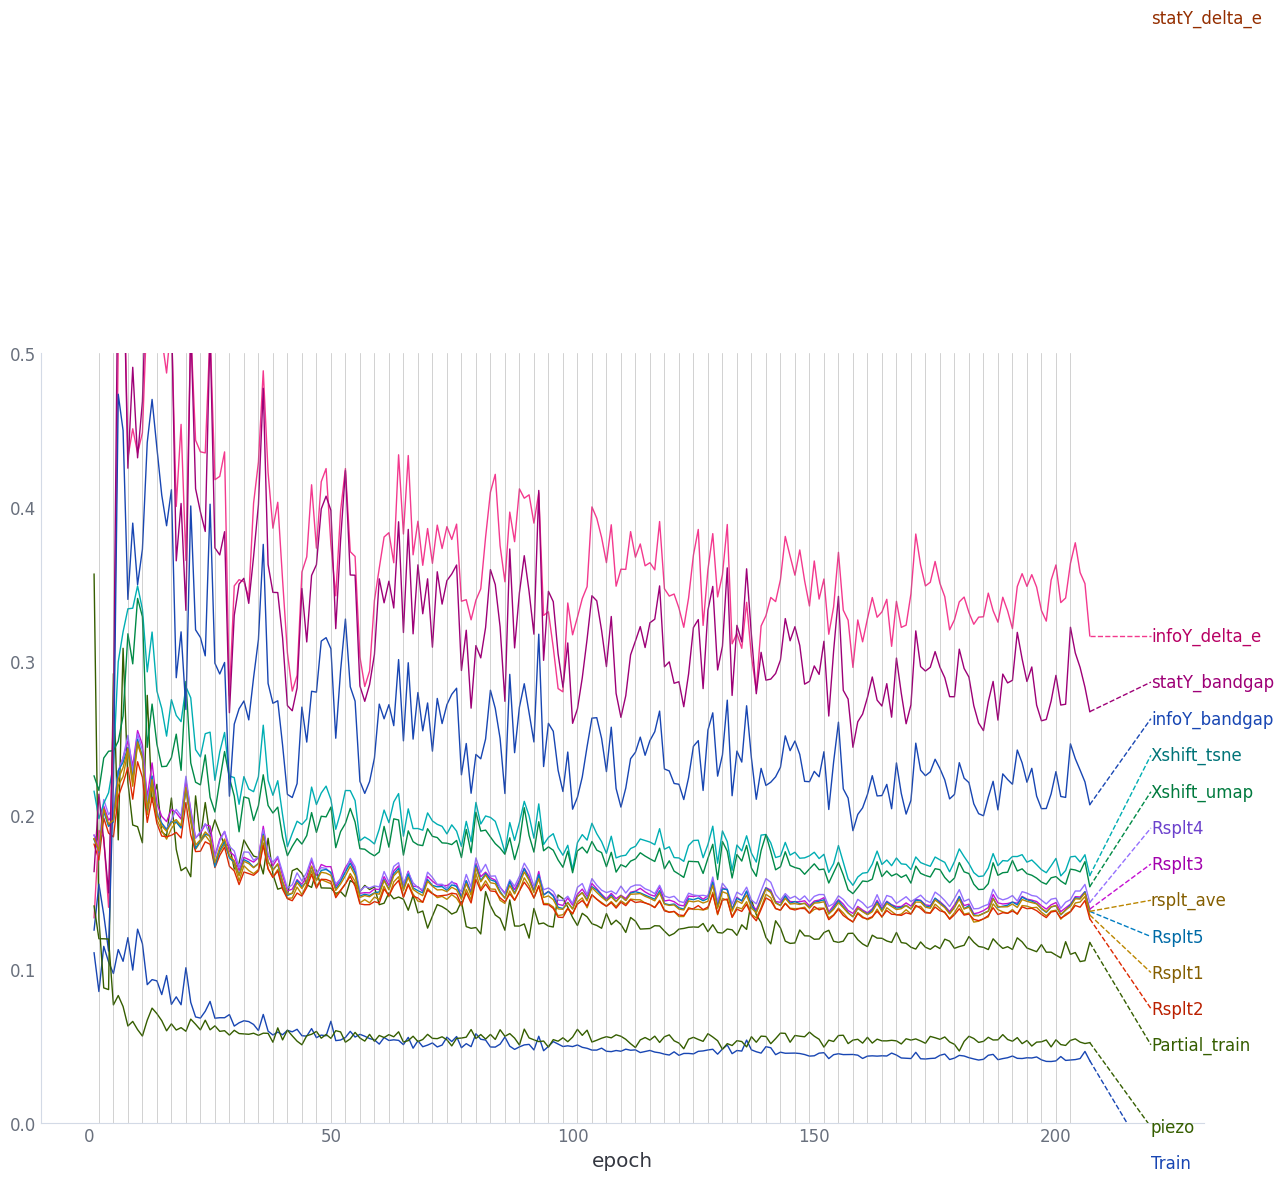

In [9]:
df = plot_logs('exp_to_compare_with_yours')

In [10]:
import torch
from glob import glob
import torch.nn as nn
class IRNet_intorch(torch.nn.Module):
    #'128-64-16'
    def __init__(self, input_size):
        super(IRNet_intorch, self).__init__()
        self.fc128 = nn.Linear(128, 128)
        self.fc64 = nn.Linear(64, 64)
        self.fc16 = nn.Linear(16, 16)

        self.bn128 = nn.BatchNorm1d(128)
        self.bn64 = nn.BatchNorm1d(64)
        self.bn16 = nn.BatchNorm1d(16)

        self.relu = nn.ReLU()
        self.inputlayer = nn.Linear(input_size, 128)

        self.con128_64 = nn.Linear(128, 64)
        self.con64_16 = nn.Linear(64, 16)
        self.output16 = nn.Linear(16, 1)

    def forward(self, x):
        x = self.inputlayer(x)

        x_res = x
        x = self.fc128(x)
        x = self.bn128(x)
        x = self.relu(x)
        x = x + x_res
        x = self.con128_64(x)

        x_res = x
        x = self.fc64(x)
        x = self.bn64(x)
        x = self.relu(x)
        x = x + x_res
        x = self.con64_16(x)

        x_res = x
        x = self.fc16(x)
        x = self.bn16(x)
        x = self.relu(x)
        x = x + x_res

        x = self.output16(x)
        return x

def get_params(model: IRNet_intorch):
    return model.inputlayer.weight.mean(dim=0).abs()

epochs = []
weights = []

with torch.no_grad():
    for name in glob('exps/delta_e_02-23-14-26/models/IR3_epoch_*.pt'):
        epoch = int(name.removesuffix('.pt').split('_')[-1])
        model = torch.load(name)

        weights.append(get_params(model))
        epochs.append(epoch)

    epochs = torch.tensor(epochs)
    weights = torch.stack(weights)

    weights = weights[torch.argsort(epochs)]
    epochs = epochs[torch.argsort(epochs)]

In [12]:
model = IRNet_intorch(145)

In [14]:
list(model.named_parameters())

[('fc128.weight',
  Parameter containing:
  tensor([[ 0.0536,  0.0339,  0.0728,  ...,  0.0180, -0.0766,  0.0620],
          [ 0.0120,  0.0017,  0.0661,  ...,  0.0542, -0.0040, -0.0556],
          [-0.0277, -0.0827,  0.0277,  ...,  0.0728,  0.0447,  0.0463],
          ...,
          [-0.0019, -0.0703, -0.0640,  ..., -0.0883, -0.0269, -0.0103],
          [ 0.0581,  0.0271,  0.0004,  ..., -0.0815, -0.0440,  0.0081],
          [ 0.0713,  0.0573,  0.0362,  ...,  0.0724,  0.0737,  0.0865]],
         requires_grad=True)),
 ('fc128.bias',
  Parameter containing:
  tensor([ 0.0204, -0.0615,  0.0022, -0.0406, -0.0761,  0.0049, -0.0685, -0.0029,
           0.0161, -0.0117,  0.0423, -0.0108,  0.0617, -0.0474, -0.0748,  0.0782,
          -0.0760, -0.0531, -0.0421, -0.0596, -0.0457,  0.0717, -0.0198, -0.0402,
          -0.0434,  0.0858,  0.0840,  0.0757,  0.0848,  0.0573,  0.0640,  0.0806,
           0.0233, -0.0057, -0.0073,  0.0422, -0.0442, -0.0670,  0.0700, -0.0259,
           0.0851,  0.0434,  

In [ ]:
from src.utils import to_np

w = to_np(weights)

data = pd.read_feather('mpc_full_feats_scaled_split.feather')
cols = data.columns[1:146]

wdf = pd.DataFrame(w, columns=cols, index=to_np(epochs))
wdf.head()

In [ ]:
high_var_cols = wdf.std(axis=0).sort_values()[::-1].head(10).index
wdf[high_var_cols].plot()
rp.line_labels()

In [ ]:
salw = torch.tensor([7.5641e+03, 1.1149e+04, 8.8050e+03, 6.5502e+03, 4.8011e+03, 4.9787e+03,
        4.8674e+03, 4.2974e+03, 5.3753e+03, 5.7287e+03, 8.2724e+03, 6.1718e+03,
        8.6208e+03, 1.0240e+04, 1.0027e+04, 8.8002e+03, 8.2256e+03, 1.0730e+04,
        6.7404e+03, 4.3592e+03, 5.1032e+03, 6.5154e+03, 7.3106e+03, 7.6345e+03,
        9.8441e+03, 1.1520e+04, 1.1624e+04, 9.4132e+03, 1.6377e+04, 7.7563e+03,
        1.0531e+04, 1.3742e+04, 1.0908e+04, 8.2601e+03, 1.1363e+04, 8.5690e+03,
        5.0495e+03, 1.2681e+04, 7.7252e+03, 5.6099e+03, 9.2453e+03, 8.2575e+03,
        6.2180e+03, 1.2382e+04, 1.6208e+04, 1.2909e+04, 1.6645e+04, 9.2930e+03,
        8.8939e+03, 1.7135e+04, 1.5762e+04, 1.4742e+04, 2.3940e+04, 8.8418e+03,
        6.7326e+03, 4.1118e+03, 8.9933e+03, 7.1492e+03, 8.0763e+03, 7.9999e+03,
        9.1089e+03, 1.0422e+04, 1.4567e+04, 1.0887e+04, 1.0490e+04, 6.1870e+03,
        1.2594e+04, 8.3835e+03, 8.5477e+03, 9.1938e+03, 1.3445e+04, 1.1119e+04,
        4.0550e+03, 7.0541e+03, 5.7408e+03, 6.8563e+03, 1.0000e+00, 7.5973e+03,
        1.0036e+04, 1.2485e+04, 1.3248e+04, 3.6473e+03, 1.3025e+04, 1.2059e+04,
        4.1526e+03, 7.2269e+03, 9.6384e+03, 9.1124e+03, 9.7935e+03, 1.0412e+04,
        7.6082e+03, 1.0772e+04, 1.0111e+04, 1.3794e+04, 2.2914e+04, 1.0869e+04,
        5.6140e+03, 7.3420e+03, 8.1755e+03, 8.1320e+03, 1.5337e+04, 9.7747e+03,
        1.5417e+03, 1.1578e+04, 1.2958e+04, 1.0241e+04, 1.4827e+04, 1.3336e+04,
        2.4689e+04, 1.5316e+04, 1.4966e+04, 2.2873e+04, 1.8989e+04, 1.5432e+04,
        1.1321e+04, 8.2973e+03, 9.8889e+03, 1.2825e+04, 1.7342e+04, 1.0677e+04,
        7.1521e+03, 8.5476e+03, 7.2192e+03, 1.1388e+04, 6.5605e+03, 1.1304e+04,
        1.3394e+03, 7.3983e+03, 7.6834e+03, 1.0150e+04, 1.0613e+04, 5.5198e+03,
        8.7780e+03, 2.1204e+04, 9.5088e+03, 1.8393e+04, 7.9973e+03, 7.5481e+03,
        8.4170e+03, 7.5423e+03, 8.8349e+03, 6.8705e+03, 2.2745e+04, 1.5653e+04,
        1.8500e+04], device='cuda:0')

salw = pd.Series(to_np(salw), index=cols)
salw.sort_values()

In [194]:
data_adv = data.query('piezo').iloc[::10, 1:146]
data_adv['epoch'] = -10
data_adv['batch'] = -3

adv = [data_adv]
for name in list(glob('exps/delta_e_02-23-14-26/adv/*.feather'))[::10]:
    epoch, batch = map(int, name.removesuffix('.feather').split('attack')[-1].split('_'))
    adv_file = pd.read_feather(name)
    adv_file['epoch'] = epoch
    adv_file['batch'] = str(batch)
    adv.append(adv_file)


adv = pd.concat(adv).sort_values('epoch').reset_index(drop=True)
adv

,0-norm,2-norm,3-norm,5-norm,7-norm,10-norm,minimum Number,maximum Number,range Number,mean Number,...,avg s valence electrons,avg p valence electrons,avg d valence electrons,avg f valence electrons,compound possible,max ionic char,avg ionic char,epoch,batch,label
0,-0.302404,-0.032556,0.033257,0.130844,0.170592,0.193219,-0.356083,1.550816,1.884130,0.081558,...,0.737291,0.859944,-0.094490,0.720958,1.125155,0.552832,0.613766,-10,-3,NaN
1,-0.302404,0.657163,0.709718,0.751668,0.765488,0.771651,-0.356083,-0.351323,-0.156691,-0.405381,...,-0.757509,0.566738,-0.810118,-0.492369,-0.888766,1.100757,1.293215,-10,-3,NaN
2,-0.302404,-0.044455,-0.237875,-0.441547,-0.531773,-0.589456,-0.748879,-1.030659,-0.642601,-1.123891,...,-1.504909,-0.270992,-0.773606,-0.492369,-0.888766,0.961428,1.565846,-10,-3,NaN
3,-0.302404,-0.688997,-0.766741,-0.752689,-0.712282,-0.673577,0.272391,-0.894792,-1.128511,-0.245204,...,-0.383809,-0.019673,0.116365,-0.492369,-0.888766,-0.651922,-0.631580,-10,-3,NaN
4,-0.302404,-0.688997,-0.766741,-0.752689,-0.712282,-0.673577,2.707728,0.735614,-0.885556,1.901172,...,-0.383809,-0.019673,1.937384,0.482626,1.125155,-0.959843,-0.941618,-10,-3,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152610,-0.302404,-1.140201,-1.376947,-1.598701,-1.703648,-1.784628,0.272391,1.279082,1.203856,1.516747,...,0.737291,0.273533,1.234535,1.529842,-0.888766,-1.487461,-1.384442,497,4,-0.576848
152611,-0.302404,-0.355159,-0.526169,-0.710944,-0.805057,-0.879671,0.272391,-0.894792,-1.128511,-0.120622,...,-1.255776,-0.215144,0.851162,-0.492369,-0.888766,-0.905746,-1.002130,497,4,-0.742720
152612,-0.302404,-0.366848,-0.495845,-0.606157,-0.641581,-0.650592,1.293662,-0.351323,-1.177102,0.555683,...,-1.504909,-0.019673,2.608286,-0.492369,-0.888766,-1.025945,-1.042094,497,4,-0.524375
152613,-0.302404,-1.140201,-1.376947,-1.598701,-1.703648,-1.784628,1.215102,1.550816,0.912311,2.221527,...,0.737291,-0.899290,1.362326,2.974279,-0.888766,-1.212133,-1.096381,497,4,-0.697987


In [208]:
(salw / np.sum(salw)).sort_values()

avg_dev NfValence            6.835873e-07
minimum GSmagmom             9.155968e-04
minimum NfUnfilled           1.053886e-03
mean NValence                2.493248e-03
minimum NfValence            2.771946e-03
                                 ...     
compound possible            1.554819e-02
mean NUnfilled               1.563569e-02
avg_dev NpUnfilled           1.566372e-02
avg_dev Electronegativity    1.636508e-02
minimum NUnfilled            1.687709e-02
Length: 145, dtype: float32

In [195]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
reducer = PCA(n_components=2)

adv[['x', 'y']] = reducer.fit_transform(scaler.fit_transform(adv.iloc[:, :145]))

In [196]:
comps = pd.Series(reducer.components_[0], adv.columns[:145])
comps.sort_values()

maximum Electronegativity   -0.150446
max ionic char              -0.145308
range Electronegativity     -0.143576
avg ionic char              -0.135261
avg_dev Electronegativity   -0.133546
                               ...   
mean Number                  0.144760
minimum MeltingT             0.147810
minimum Row                  0.150894
minimum CovalentRadius       0.150986
mean Row                     0.151026
Length: 145, dtype: float32

<Axes: xlabel='epoch', ylabel='x'>

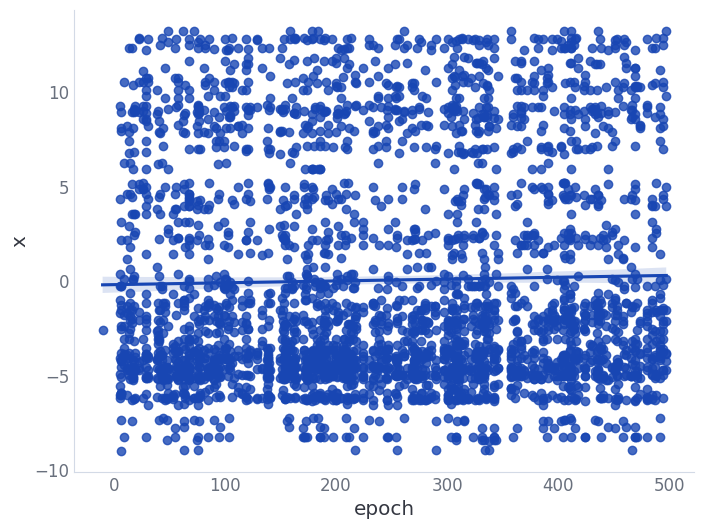

In [197]:
sns.regplot(adv.iloc[::47], x='epoch', y='x')

<Axes: xlabel='x', ylabel='y'>

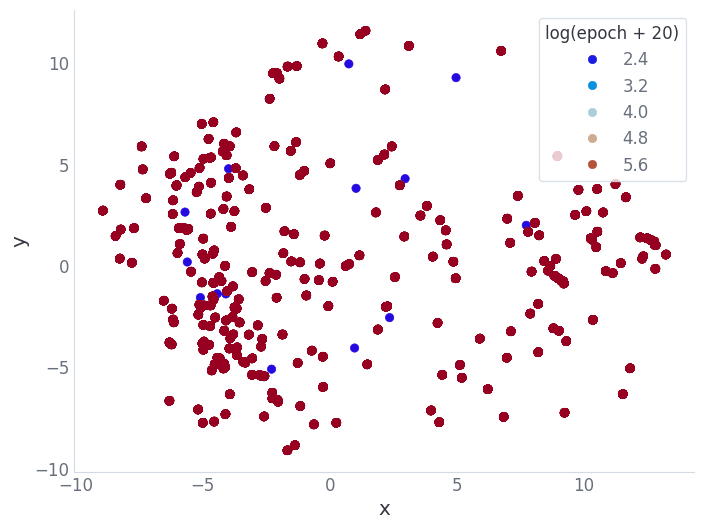

In [201]:
sns.scatterplot(adv.query('epoch % 5 == 1 or epoch < 0'), hue='log(epoch + 20)', palette='rho_diverging', x='x', y='y', ec=None)

<Axes: xlabel='time_iter', ylabel='max ionic char'>

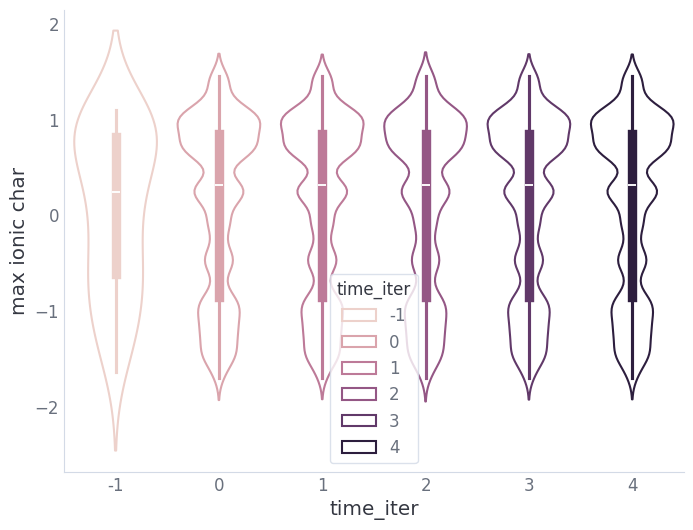

In [214]:
adv['time'] = (adv['epoch'] // 20).astype(str)
adv['time_iter'] = np.where(adv['epoch'] < 0, adv['epoch'] // 10, adv['epoch'] % 5)

sns.violinplot(adv, x='time_iter', y='max ionic char', fill=False, hue='time_iter')

In [218]:
adv.groupby('time_iter').mean(numeric_only=True)

,0-norm,2-norm,3-norm,5-norm,7-norm,10-norm,minimum Number,maximum Number,range Number,mean Number,...,avg p valence electrons,avg d valence electrons,avg f valence electrons,compound possible,max ionic char,avg ionic char,epoch,label,x,y
time_iter,,,,,,,,,,,,,,,,,,,,,
-1,-0.302404,-0.244023,-0.302472,-0.339561,-0.352367,-0.360399,0.171674,0.269949,0.183446,0.249284,...,0.184103,0.152786,0.210731,0.144014,0.048673,0.144401,-10.000000,NaN,0.426584,0.869125
0,-0.302397,-0.242993,-0.300887,-0.344086,-0.362699,-0.376107,0.146886,0.328015,0.261078,0.246237,...,0.220950,0.170617,0.232912,0.283406,0.085684,0.178823,254.298246,-1.712299,-0.000274,-0.000402
1,-0.302403,-0.242992,-0.300890,-0.344094,-0.362705,-0.376109,0.146887,0.328014,0.261080,0.246242,...,0.220951,0.170612,0.232909,0.283407,0.085687,0.178825,262.884058,-1.712299,0.000034,-0.000036
2,-0.302405,-0.242991,-0.300886,-0.344091,-0.362700,-0.376110,0.146887,0.328015,0.261081,0.246244,...,0.220952,0.170610,0.232903,0.283408,0.085687,0.178825,233.785714,-1.712299,0.000045,-0.000035
3,-0.302406,-0.242994,-0.300894,-0.344100,-0.362702,-0.376112,0.146888,0.328010,0.261081,0.246242,...,0.220951,0.170611,0.232900,0.283402,0.085686,0.178823,236.730159,-1.712299,0.000003,-0.000103
4,-0.302405,-0.242994,-0.300893,-0.344102,-0.362701,-0.376116,0.146884,0.328015,0.261084,0.246252,...,0.220940,0.170617,0.232904,0.283405,0.085688,0.178820,250.119403,-1.712299,-0.000317,-0.000490
